### Imports

In [1]:
# General Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
# We want to predict Claim Injury Type

In [ ]:
# Neeed to create utils.py, model.py and a way to store/load the trained models.

# To-Do List: EDA, Preprocessing, and Data Preparation

**Our target is Claim Injury Type**

## 1. Exploratory Data Analysis (EDA)
   - **1.1 Data Overview**
     - Inspect the dataset structure.
     - Check for missing values (NAs) in each column. (There are missing values in the target, what's the % of NAs for each column)
     - Analyze basic statistics for numerical features (mean, median, min, max, etc.). ( .info and .describe)
     - Investigate categorical features (value counts, unique values).
     - Identify anomalies and duplicates in the data. (Age being NA is different from being 0 and Zip Code can be either a str or an int)

   - **1.2 Correlations and Relationships**
     - Compute correlation matrix for numerical features. (Can be done after dealing with categorical variables)
     - Identify and analyze feature relationships with target class using plots (e.g., boxplots, violin plots, histograms).

   - **1.3 Target Variable Analysis**
     - We should do it before and after preprocessing (maybe?).
     - Analyze class distribution of the target variable (severely unbalanced).
     - Identify potential patterns between features and classes with less data.
     - Discuss and visualize how imbalance could affect model performance.

## 2. Data Preprocessing
   - **2.1 Handling Missing Data and Anomalies**
     - Treat missing values (e.g., imputation, deletion). (We drop the ones that are in the target)
     - Convert variables that have contextual NAs into dummies (C-2 Date and C-3 Date could be NAs because at the time were yet to happen so they can become C-2 Ocurred, 0 or 1)

   - **2.2 Feature Engineering**
     - **2.2.1 Date Features**
       - Convert date features (e.g., `Accident Date`, `C-2 Date`) into meaningful time variables (e.g., days from a reference date).
       - For now we are calling the new feature related to date `feature` Days, we should decide a better name.
     - **2.2.2 Age**
       - Convert birth year into age in years.
       - We could group by Age and search for patterns.

   - **2.3 Categorical Feature Encoding**
     - **Nominal Features**
       - Apply Frequency Encoding (or Target Encoding, IDK if it is possible) for categorical features with many unique values (e.g., `Carrier Name`).
       - (We don't use Label Encoding for these features because it would imply a rank between them)
       - (One-Hot-Encoder creates a column for each class, so the dataset becomes a mess)
     - **Ordinal Features**
       - Apply Label Encoding for features with natural order (e.g., `Claim Injury Type`).
       - Ensure correct ordering during the encoding process. (Need to check this)
     - **Store Original Values**
       - Store encodings and the original values for potential reverse-mapping in future analysis. (Needed for submission)

   - **2.4 Feature Scaling**
     - Scale Data. (numerical features only)
     - Scale train and validation/test datasets separately to avoid data leakage.

## For now we don't need to worry with the steps below.

## 3. Dealing with Imbalanced Data (GPT suggested this)
   - **3.1 Resampling Techniques**
     - **Oversampling**: Try SMOTE or ADASYN to oversample minority classes.
     - **Undersampling**: Consider random undersampling of the majority class.
   - **3.2 Anomaly Detection**
     - Consider integrating anomaly detection methods like Isolation Forest for rare events or minority classes.
   - **3.3 Class Weights**
     - Modify class weights in models to give more importance to underrepresented classes.

## 4. Data Splitting
   - **4.1 Train-Validation Split**
     - Ensure proper splitting of data into train and validation.
     - Use stratified splitting to preserve the class distribution across datasets.
     - Use K-fold (and other splitting methods to deal with unbalanced dataset).

## 5. Baseline Model Training
   - **5.1 Baseline Models**
       - Create lists with different feature and parameters.
       - Select Baseline Models (e.g., Decision Tree, Logistic Regression, RandomForest)
       - Train models iterating through the lists.
   - **5.2 Gridsearch**
       - After having 1 or 2 models that outperform the other we try to optimise their preformace 
       - Very time consuming and resource intensive 

## 6. Predict Test
   - **6.1 Prepare Test**
       - Load Test.
       - Preprocess and Scale.
       - Load final model (saved in a file) and predict target
       - Decoded Target (from 0-8 to text)
       - Load submission sample and add predicted values
       - Profit
    
## 7. Train a NN
   - **7.1 How to NN**
       - Neural Networks are something that we will learn little in ML, in the 2º semester we will have Deep Learning that focus in NNs.
       - We shouldn't make direct comparisons to the other models
       - It can be a little hit or miss and not everyone can run them


### EDA will consiste of:
    - In-depth exploration of the dataset. 
    - Feature creation, in order to better explain the information
    - Find trends, patterns or anomalities.


In [3]:
# For this study we will consider all dates in reference to 25 of Dec of 2023
reference_date = pd.to_datetime("2023-12-25")

### Import Train dataset and view

In [4]:
test_df = pd.read_csv("./data/test_data.csv")

In [5]:
train_df = pd.read_csv("./data/train_data.csv", dtype={ 29 : str})

In [6]:
train_df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


In [7]:
for col in train_df.columns:
    if col not in test_df.columns:
        print(col +" not in test")

Claim Injury Type not in test
Agreement Reached not in test
WCB Decision not in test


In [8]:
train_df["Claim Injury Type"].unique()

array(['2. NON-COMP', '4. TEMPORARY', nan, '3. MED ONLY',
       '5. PPD SCH LOSS', '6. PPD NSL', '1. CANCELLED', '8. DEATH',
       '7. PTD'], dtype=object)

In [9]:
train_df["Claim Injury Type"].value_counts()

Claim Injury Type
2. NON-COMP        291078
4. TEMPORARY       148507
3. MED ONLY         68906
5. PPD SCH LOSS     48280
1. CANCELLED        12477
6. PPD NSL           4211
8. DEATH              470
7. PTD                 97
Name: count, dtype: int64

The dataset is very unbalanced: </br>
    - PPD NSL, DEATH and PTD combined got less than 5k 

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [11]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age at Injury,574026.0,4.211427e+01,1.425643e+01,0.0,31.0,42.0,54.0,117.0
Average Weekly Wage,545375.0,4.910883e+02,6.092918e+03,0.0,0.0,0.0,841.0,2828079.0
Birth Year,544948.0,1.886768e+03,4.146444e+02,0.0,1965.0,1977.0,1989.0,2018.0
Claim Identifier,593471.0,2.366760e+07,1.079271e+08,5393066.0,5593414.5,5791212.0,5991000.5,999891667.0
IME-4 Count,132803.0,3.207337e+00,2.832303e+00,1.0,1.0,2.0,4.0,73.0
Industry Code,564068.0,5.864531e+01,1.964417e+01,11.0,45.0,61.0,71.0,92.0
OIICS Nature of Injury Description,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WCIO Cause of Injury Code,558386.0,5.438114e+01,2.587428e+01,1.0,31.0,56.0,75.0,99.0
WCIO Nature of Injury Code,558369.0,4.101384e+01,2.220752e+01,1.0,16.0,49.0,52.0,91.0
WCIO Part Of Body Code,556944.0,3.973815e+01,2.236594e+01,-9.0,33.0,38.0,53.0,99.0


In [12]:
train_df["WCB Decision"].unique()
# Very weird, we cannot assume that nan are Work Related cases as the decision is unknown at the start of claim

array(['Not Work Related', nan], dtype=object)

In [13]:
verbose = False

In [14]:
if verbose:
    for column in train_df.columns:
        print(f"{column} consistes of the following values:")
        print("-------------------------------------------------------")
        print(train_df[column].value_counts())
        print("-------------------------------------------------------")
        print("\n")

### Missing value, Dups and Feature encoding

#### See if there are missing values on the target

In [15]:
nan_count = train_df["Claim Injury Type"].isna().sum()
print(f"We found that {nan_count/train_df.shape[0] * 100}% of the training data has NAs on the target, therefor we will drop it.")
#nan_rows.value_counts
train_df = train_df.dropna(subset=["Claim Injury Type"])

We found that 3.276486972404717% of the training data has NAs on the target, therefor we will drop it.


#### See if there are duplicates on the dataset

In [16]:
dup_rows = train_df.duplicated()
dup_rows.value_counts()

False    574026
Name: count, dtype: int64

In [17]:
def multiencoder(dataset:pd.DataFrame, features:list, encoder_type:str, encoders_dict:dict = {}) -> (dict):
    
    if encoder_type == "binary":
        
        for feature in features:
            le = LabelEncoder()
            dataset[feature] = le.fit_transform(dataset[feature])
            encoders_dict[feature] = le
    
    elif encoder_type == "frequency":
            
        for feature in features:  
            freq_encoding = dataset[feature].value_counts(normalize=True)
            dataset[feature] = dataset[feature].map(freq_encoding)
            encoders_dict[feature] = {val: float(freq) for val, freq in zip(freq_encoding.index, freq_encoding.values)}
    
    else:
        print("Invalid Encoder")
    return
        
    #return encoders_dict

### Converting categorical variables to numerical 
 We have to mind if they are nominal or ordinal

In [18]:
# New to change zip to str to use freq 

features_to_encode_freq = [
    "Alternative Dispute Resolution",  "Carrier Name", 
    "County of Injury", "District Name", "Gender", "Medical Fee Region"]

features_to_encode_binary = ["Attorney/Representative", "COVID-19 Indicator", "Carrier Type", "Claim Injury Type"]

#features_to_encode_ordinal = ["Carrier Type", "Claim Injury Type"]

features_to_metadata = [ "Claim Identifier",
    "OIICS Nature of Injury Description",
    "Industry Code Description", "WCIO Cause of Injury Description", "WCIO Cause of Injury Description",
    "WCIO Nature of Injury Description", "WCIO Part Of Body Description"
]

encoders_dict = {}

multiencoder(train_df, features_to_encode_freq, "frequency", encoders_dict)
multiencoder(train_df, features_to_encode_binary, "binary", encoders_dict)

#### Feature engineering and date to days/years

In [19]:
def gen_dummy(dataset:pd.DataFrame, features:list) -> None:
    for feature in features:
        dataset[feature + "Occurred"] = dataset[feature].notna().astype(int)
    return

In [20]:
features_to_dummy = ['First Hearing Date', 'C-2 Date', 'C-3 Date']
gen_dummy(train_df,features_to_dummy)

In [21]:
def date_to_number(dataset:pd.DataFrame, features:list) -> None:  
    for feature in features:       
        if feature == "Birth Year":
            dataset["Age"] = 2023 - dataset[feature]
        else:
            new_name = feature.replace("Date","Days")
            dataset[new_name] = (reference_date - pd.to_datetime(dataset[feature], errors='coerce')).dt.days
    return

In [22]:
features_to_days = ["Accident Date", "Assembly Date", "First Hearing Date", "Birth Year"]
date_to_number(train_df, features_to_days)

In [23]:
features_to_drop = features_to_metadata + features_to_days + ["C-2 Date", "C-3 Date"]

for feature in features_to_drop:   
    try:
        train_df = train_df.drop(feature, axis = 1)
    except:
        print(f"{feature} no longer in train_df")

WCIO Cause of Injury Description no longer in train_df


In [24]:
#### Feature Selection

In [25]:
X = train_df.drop(["Claim Injury Type","Agreement Reached", "WCB Decision"], axis = 1)
y = train_df["Claim Injury Type"]

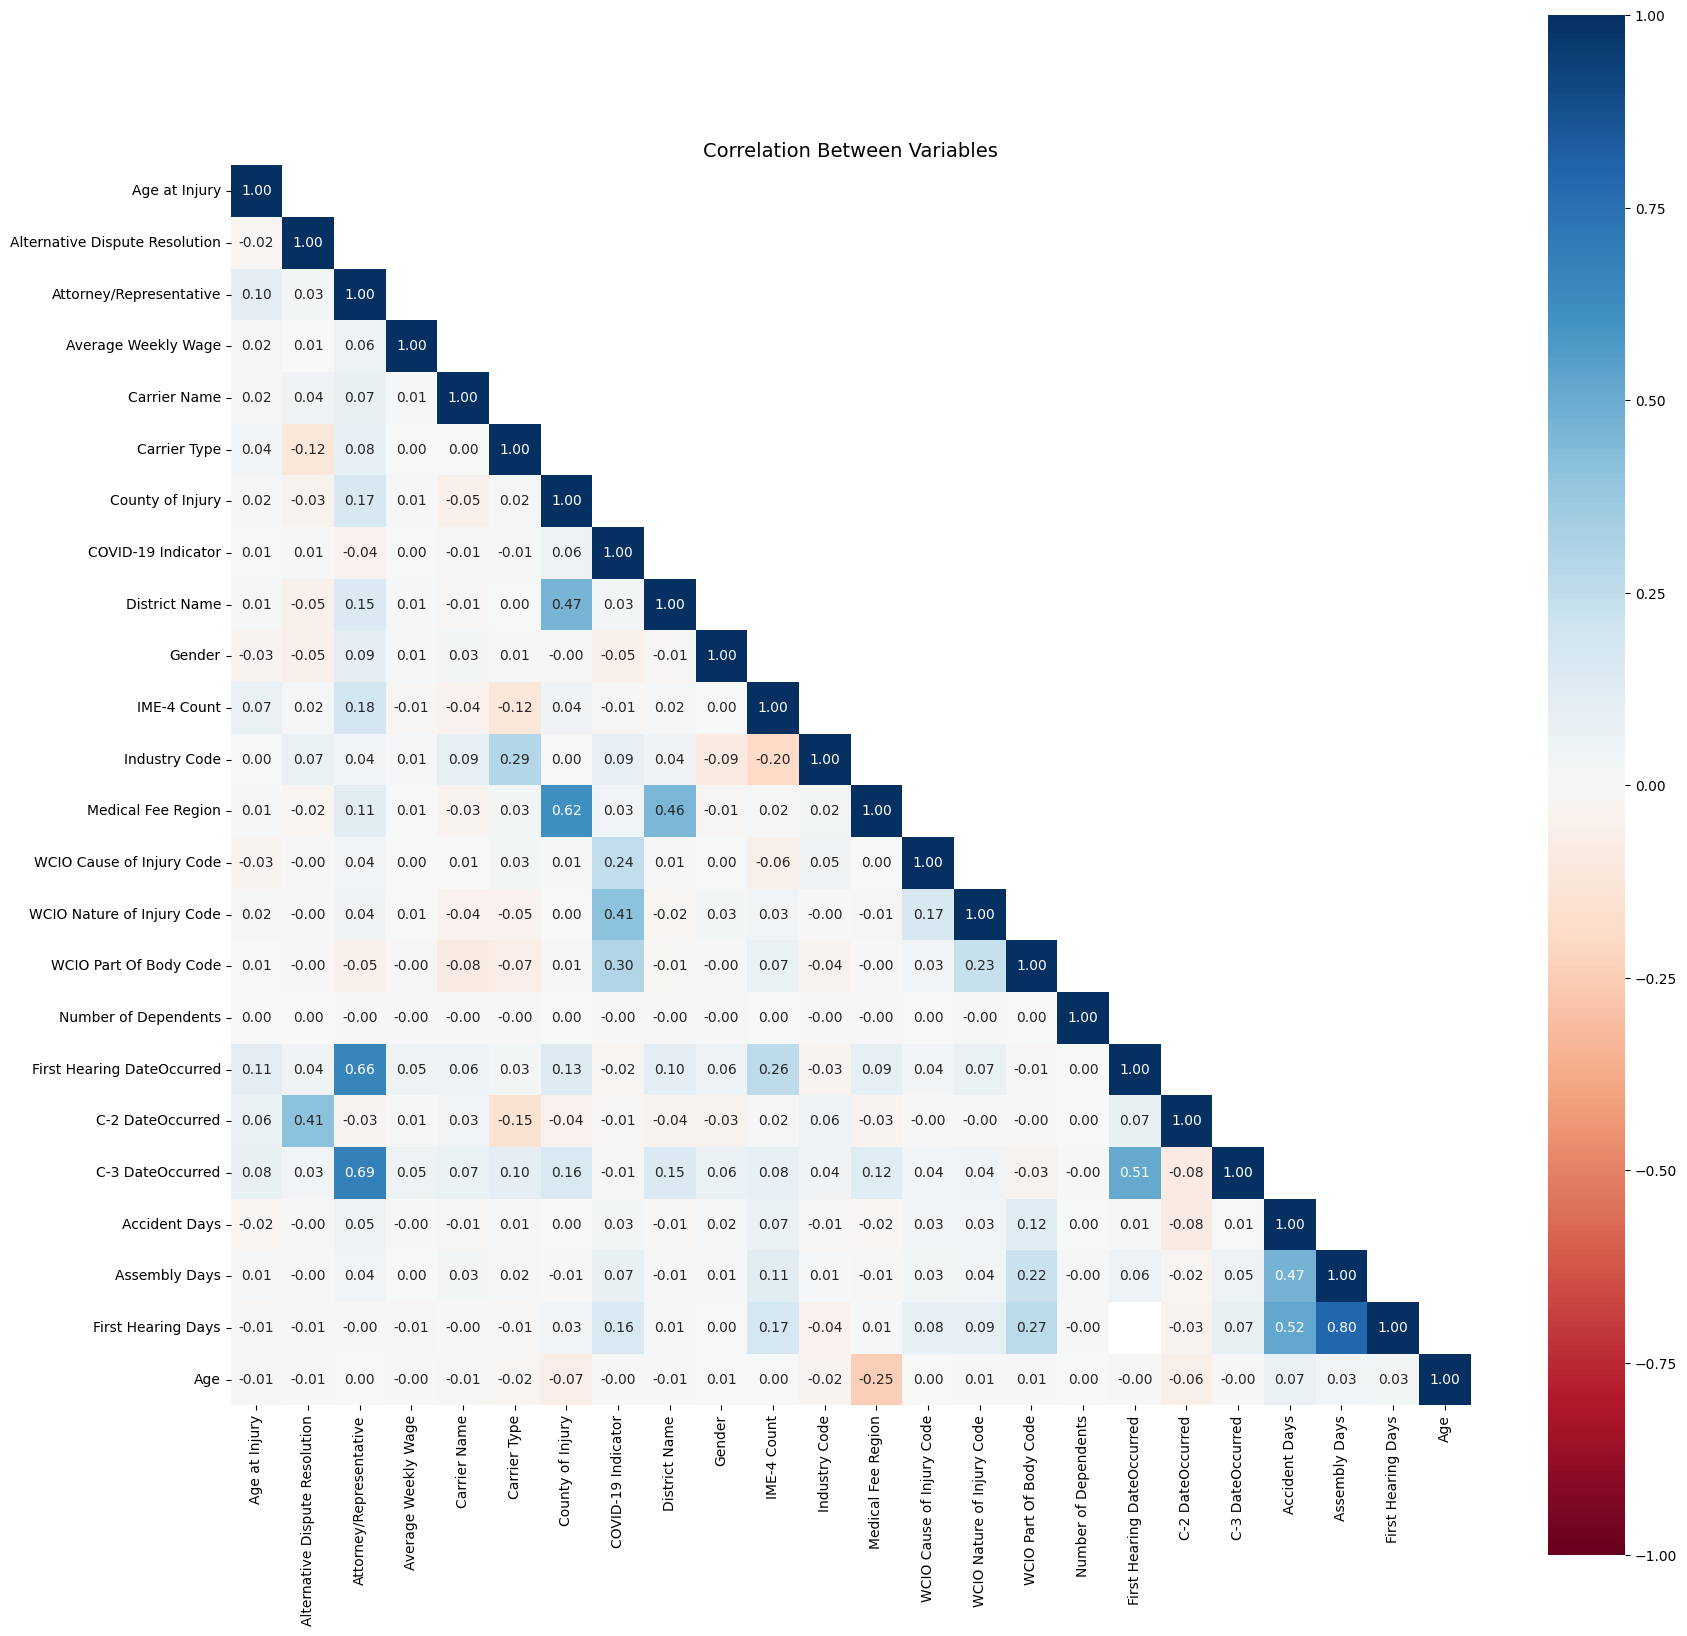

In [26]:
# initial correlation matrix with the respective values
corr_matrix = X.drop(['Zip Code'], axis = 1).corr()

mask = np.tri(*corr_matrix.shape, k=0, dtype=bool)
# Keeps values where mask is True
corr_matrix = corr_matrix.where(mask) 

# defines the figure size
fig, ax = plt.subplots(figsize=(20, 20))
# heatmap of the initial correlation matrix
l = sns.heatmap(corr_matrix, square=True, annot=True, fmt=".2f", vmax=1, vmin=-1, cmap='RdBu', ax=ax)
plt.title('Correlation Between Variables', size=14)
plt.show()

# Model Train

In [27]:
# should do RFE and Lasso to see importance 
# we still have a lot of missing values and things to do before we start modeling

In [28]:
X = X.drop(['Zip Code'], axis=1)

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.25, random_state = 42, stratify = y, shuffle = True)
mm = MinMaxScaler()
X_train = mm.fit_transform(X_train)
X_val = mm.transform(X_val)
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=None).fit(X_train, y_train)
dt_train_pred = dt.predict(X_train)
dt_val_pred = dt.predict(X_val)

In [30]:
print("Classification Report for Training Data:")
print(classification_report(y_train, dt_train_pred))

# Generate the classification report for validation data
print("Classification Report for Validation Data:")
print(classification_report(y_val, dt_val_pred))

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.74      0.38      0.51      9358
           1       0.83      0.98      0.90    218308
           2       0.52      0.01      0.02     51679
           3       0.66      0.91      0.76    111380
           4       0.71      0.25      0.37     36210
           5       0.00      0.00      0.00      3158
           6       0.00      0.00      0.00        73
           7       0.00      0.00      0.00       353

    accuracy                           0.77    430519
   macro avg       0.43      0.32      0.32    430519
weighted avg       0.73      0.77      0.70    430519

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.75      0.40      0.52      3119
           1       0.83      0.98      0.90     72770
           2       0.56      0.01      0.02     17227
           3       0.66      0.91      0.76     

# Predict Test

In [31]:
#test_df = pd.read_csv("./data/test_data.csv")

In [32]:
#encoders_dict["Claim Injury Type"] # need to inverse transform

In [33]:
test_encoder_dict = {}

In [34]:
features_to_encode_binary.remove("Claim Injury Type")

In [35]:
multiencoder(test_df, features_to_encode_freq, "frequency", test_encoder_dict)
multiencoder(test_df, features_to_encode_binary, "binary", test_encoder_dict)
gen_dummy(test_df,features_to_dummy)
date_to_number(test_df, features_to_days)

In [36]:
test_df = test_df.drop(features_to_drop + ['Zip Code'], axis = 1)

In [37]:
X_test = mm.transform(test_df)

In [38]:
dt_pred = dt.predict(X_test)

In [39]:
submission = pd.read_csv("./data/sample_submission.csv")

In [40]:
submission["Claim Injury Type"] = dt_pred

In [41]:
submission["Claim Injury Type"] = encoders_dict["Claim Injury Type"] .inverse_transform(submission["Claim Injury Type"])

In [42]:
def update_counter(file_path):
    
    try:
        with open(file_path, 'r') as file:
            count = int(file.read().strip())  
    except FileNotFoundError:
        count = 0  

    count += 1

    with open(file_path, 'w') as file:
        file.write(str(count))

    return count  

In [43]:
make_csv = False

In [44]:
if make_csv:
    version = update_counter("./counter.txt")
    submission.to_csv(f"./submissions/Group45_Version{version:02}.csv", index=False)